# Mortality ad Population Rate Growth

AIM: Since ISTAT provides some data about mortality, compare this with "my" population growth rate (PGR), which accounts both for mortality and imigration balance. Check if my assumptions on neglecting immigration above 60yo and mortality under 50ys is reasonable.


In [49]:
import warnings 
from istatapi import discovery, retrieval
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import plotly.express as px

warnings.filterwarnings('ignore')
requests.urllib3.disable_warnings() # avoid "InsecureRequestWarning: Unverified HTTPS request is being made to host 'sdmx.istat.it'. Adding certificate verification is strongly advised"

In [2]:
# I want to know the deaths to split them from the immigration balance
ds = discovery.DataSet(dataflow_identifier="DCIS_MORTALITA1") # Deaths in Italy http://dati.istat.it/Index.aspx?lang=en&DataSetCode=DCIS_MORTALITA
ds.set_filters(itter107 ="IT", sesso="9")
df = retrieval.get_data(ds) # Takes about 30s
df

,DATAFLOW,FREQ,ETA_CLASSI_ETA,ITTER107,SESSO,FUNZ_BIO,TIME_PERIOD,OBS_VALUE,BREAK,CONF_STATUS,OBS_PRE_BREAK,OBS_STATUS,BASE_PER,UNIT_MEAS,UNIT_MULT,METADATA_EN,METADATA_IT
0,IT1:26_295(1.1),A,Y_UN4,IT,9,DEATHS,1974-01-01,2735.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20000,IT1:26_295(1.1),A,Y40,IT,9,PYLIVED,1974-01-01,94544.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19950,IT1:26_295(1.1),A,Y40,IT,9,PROJPROB,1974-01-01,0.997919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19900,IT1:26_295(1.1),A,Y40,IT,9,PROBDEATH,1974-01-01,1.961550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42800,IT1:26_295(1.1),A,Y98,IT,9,PYLIVED,1974-01-01,331.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27999,IT1:26_295(1.1),A,Y60,IT,9,LIFEXP,2023-01-01,25.256000,NaN,NaN,NaN,e,NaN,NaN,NaN,NaN,NaN
27949,IT1:26_295(1.1),A,Y60,IT,9,DEATHS,2023-01-01,453.000000,NaN,NaN,NaN,e,NaN,NaN,NaN,NaN,NaN
27899,IT1:26_295(1.1),A,Y6,IT,9,SURVIVORS,2023-01-01,99694.000000,NaN,NaN,NaN,e,NaN,NaN,NaN,NaN,NaN
29099,IT1:26_295(1.1),A,Y62,IT,9,SURVIVORS,2023-01-01,93650.000000,NaN,NaN,NaN,e,NaN,NaN,NaN,NaN,NaN


In [5]:
# Take only the probability of death and prepare a dataframe similar to the PGR one, for comparison
df_pgrdeath = (
    df.copy()
    .query("FUNZ_BIO=='PROBDEATH'")
    .query("~ETA_CLASSI_ETA.str.contains('-|_')") # filter out rows containing "-" or "_"
    .assign(age= lambda x: x["ETA_CLASSI_ETA"].str.split("Y").str[-1].astype(int))
    .assign(year= lambda x: x["TIME_PERIOD"].dt.year)
    .filter(["year", "age", "OBS_VALUE"])
    .sort_values(["year", "age"])
    .reset_index(drop=True)
    .pivot(index='age', columns='year', values='OBS_VALUE')
    .divide(-1000) # convert probability to (negative) population growth rate
    .astype(float)
    .loc[:100,:]
)
df_pgrdeath.to_csv("data/4_pgrdeath_by_age_year.csv")

In [21]:
dfp = pd.read_csv("data/1_population_by_age_year.csv", index_col=0)
df_pgr = pd.read_csv("data/1_pgr_by_age_year.csv", index_col=0)
df_pgrdeath = pd.read_csv("data/4_pgrdeath_by_age_year.csv", index_col=0)
dfp.columns = dfp.columns.astype(int)
df_pgr.columns = df_pgr.columns.astype(int)
df_pgrdeath.columns = df_pgrdeath.columns.astype(int)

df_pgrdeath = (
    df_pgrdeath
    .assign(**{"2024":None})
    .shift(1, axis=1) # Comparing the COVID spikes, I think they refer to the end of the year, not the beginning, so OI have to shift
    .drop(df_pgrdeath.columns[0], axis=1)
)
# keep only the years and ages that are also in PGR
years = [ x for x in df_pgr.columns if x in df_pgrdeath.columns]
ages = [ x for x in df_pgr.index if x in df_pgrdeath.index]
df_pgrdeath = df_pgrdeath.loc[ages, years]

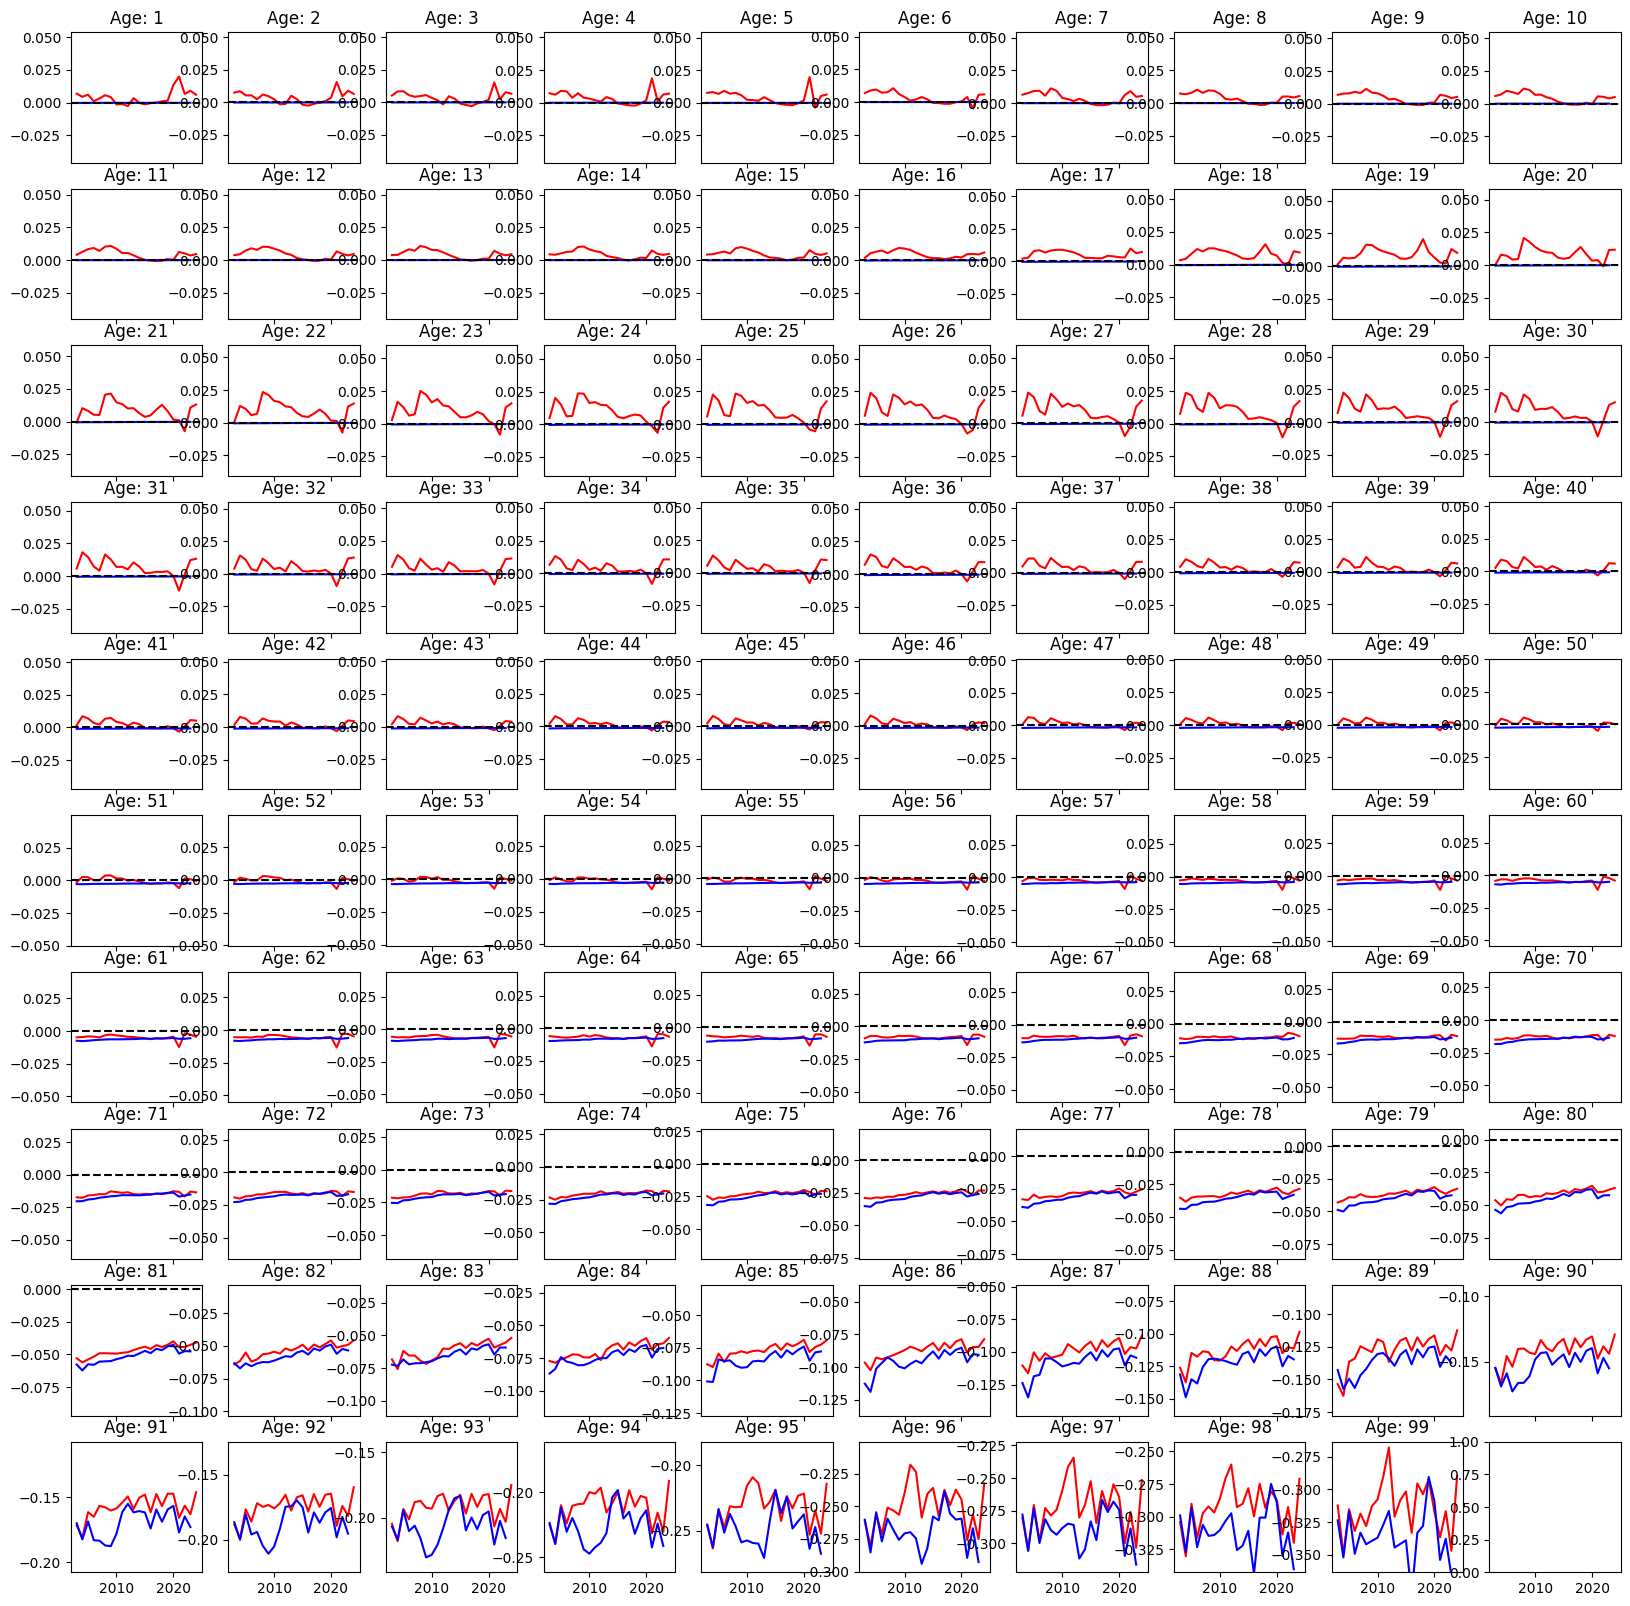

In [18]:
fig, axs = plt.subplots(10,10, figsize=[20, 20], sharex=True)
for iplot, age in enumerate(ages):
    ax = axs.flatten()[iplot]
    ax.plot(df_pgr.columns, df_pgr.loc[age].values, label=age, color="red")
    ax.plot(df_pgrdeath.columns, df_pgrdeath.loc[age].values, label=age, color="blue")
    ax.set_title(f"Age: {age}")
    ax.axhline(0, color="black", linestyle="--")
    y_avg = df_pgr.loc[age].values.mean()
    y_margin = 0.05 # choose resonable values to fully show all the markers 
    ax.set_ylim(y_avg-y_margin, y_avg+y_margin) # note that I keep the same scale for all the plots, but transposed
    #ax.set_ylim(-0.3,0.02)
plt.show()

For people younger than 60 let's try to compute somerough estimate of the number of migrants. <br>
Indeed, it does not make sense for the model to consider the migation balance as PGR, i.e., ratio to the current population. 

I want some average number of migrants to add them age by age in my future projection, under different scenarios.

PS: I know that the "PGR-death" I obrained form the death probability is some sort of average I can not subract directly to PGR,
 but at the end I'm taking some average in the last two decades so it is a reasonable calculations for the data I have!

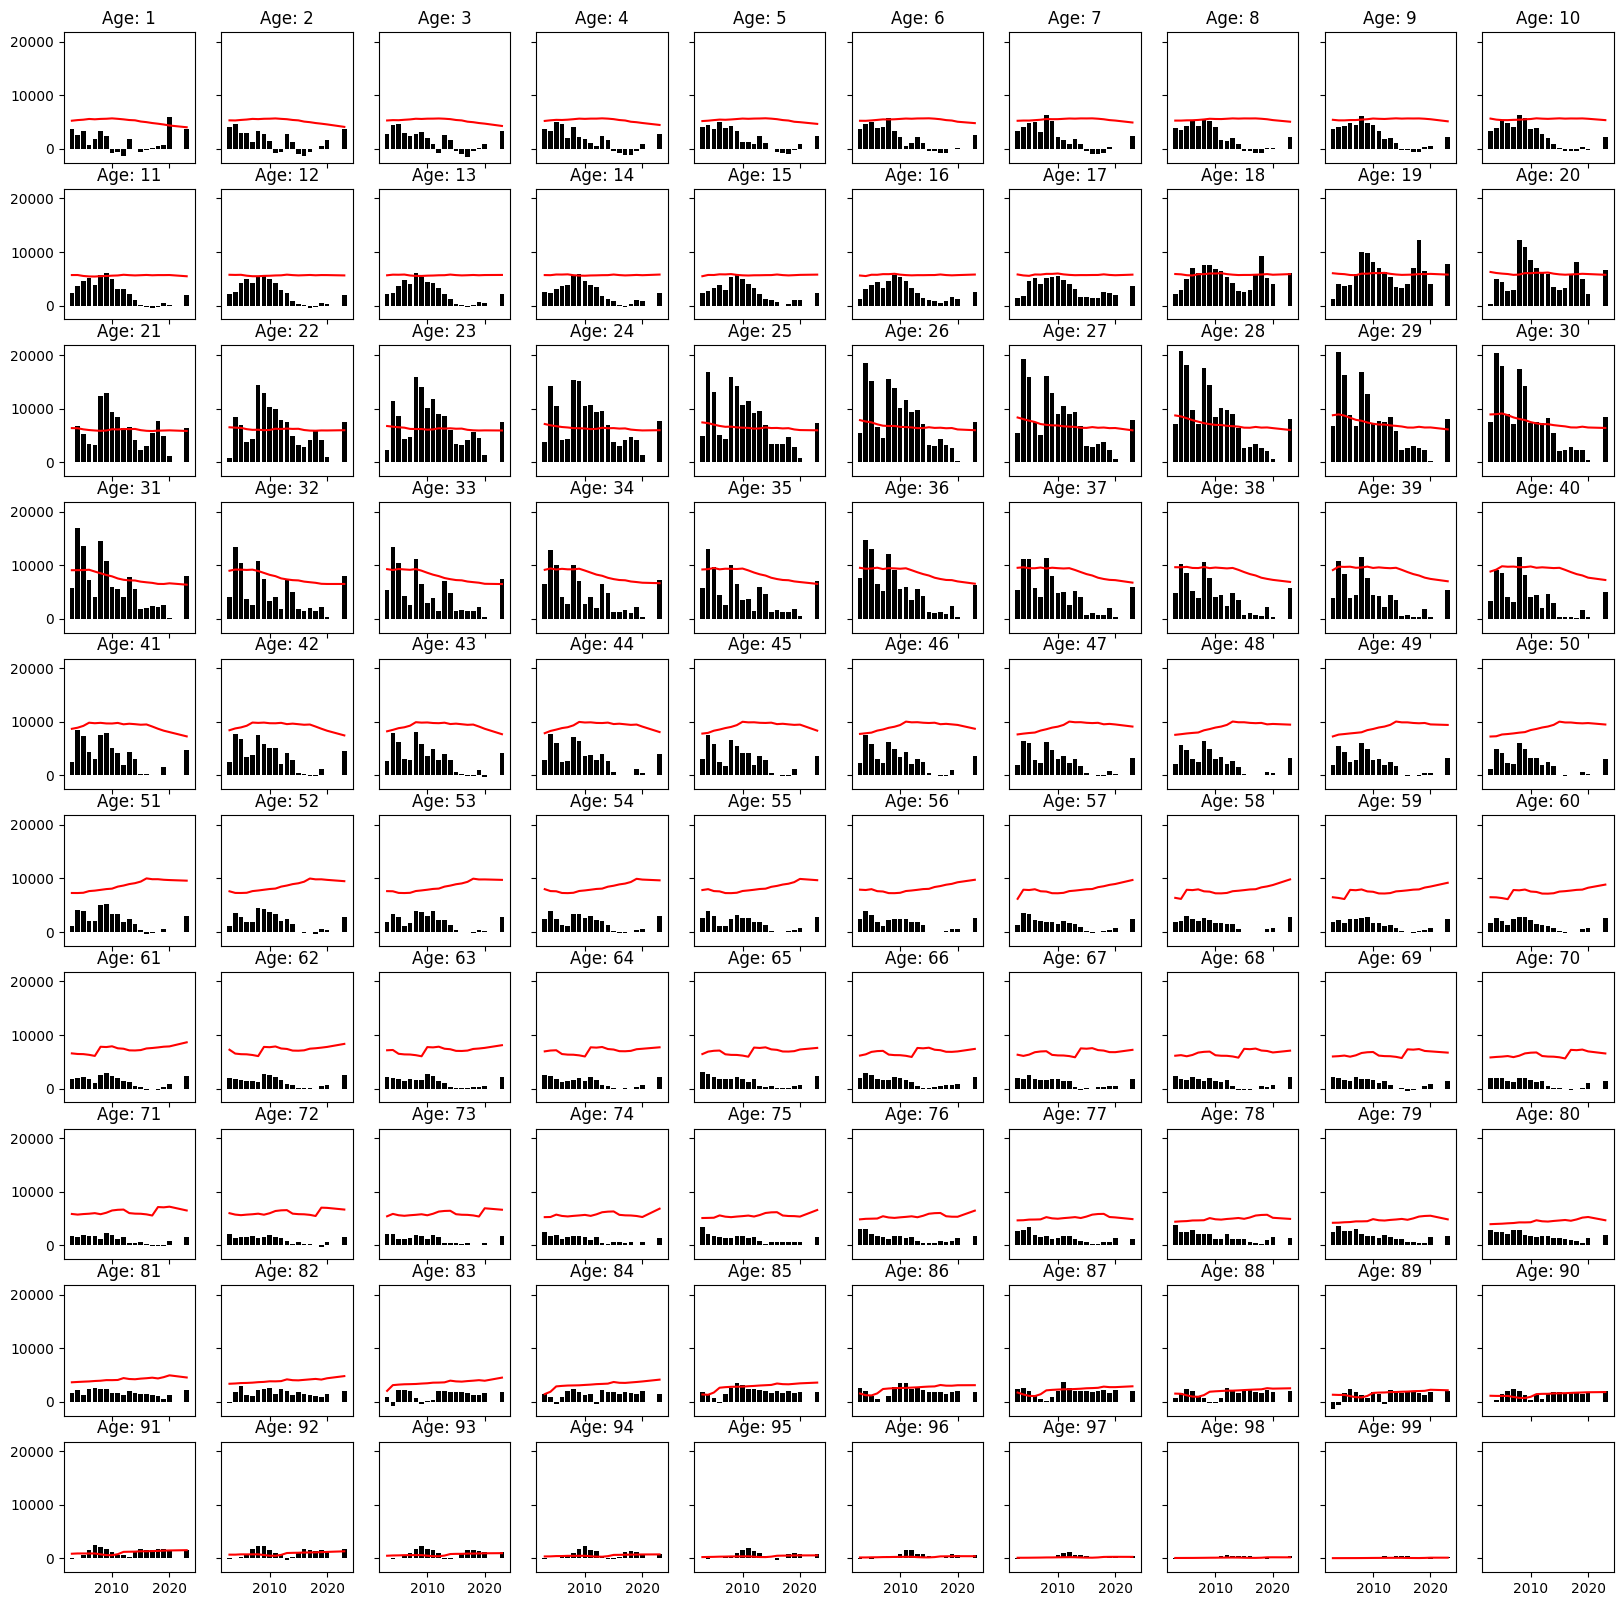

In [48]:
df_migrants = (
    ((df_pgr - df_pgrdeath) * dfp)
    .loc[ages, :] 
    .loc[:, [y for y in range(2003,2024) if y not in [2021, 2022]] ] # excluding COVID years where the PGR and death-prob are not consistent
)
fig, axs = plt.subplots(10,10, figsize=[20, 20], sharex=True, sharey=True)
for iplot, age in enumerate(df_migrants.index):
    ax = axs.flatten()[iplot]
    ax.bar(df_migrants.columns, df_migrants.loc[age].values, color="black")
    ax.plot(df_migrants.columns, dfp.loc[age, df_migrants.columns]/100, color="red")
    ax.set_title(f"Age: {age}")
plt.show()

In this plot I'm plotting the estimate number of migrants (excluding COVID years) in black bars and in red the population/100. <br>
This means that if the bar touches the red line, that year 1% of the population of that age is an immigrant. 

For people older than 60, the migration balance is probably noise in the measurement, having a little sample.

I can see if these numbers make sense by comparing:
-  with [this document](https://www.istat.it/it/files//2020/05/Migrazioni_EN.pdf), where the number of net migrant is about 350k-175k in the range 2009-2018. 
- [The world bank also reports data](https://data.worldbank.org/indicator/SM.POP.NETM?locations=IT) for a longer historical period.  

Note that the balance is pretty weavy, with a 10x difference between the maximum and the minimum.

Data are pretty consistent with the next barplot (remember to shift by one year, the year refers here to the first of January).

In [52]:
px.bar(df_migrants.sum()).update_layout(title="Net Migrant Population")

In [53]:
df_migrants.to_csv("data/5_migrants_by_age_year.csv")

## Conclusions

The assumptions that I considered in notebook#3 seems reasonable when comparing the death probability:
- under age of 60 I can assume that the mortality is negligible and sum an average number of migrants
- NOTE: the mortality IS NOT nul, but it is very small when compared to the uncertainty on the migration balance
- I will use the migration balance sum in notebook#3 to make scenarios for the future
- over 60 I can assume that the migration balance is negligible and use just the PGR to evolve the population